In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_continuous_cols, convert_categorical_to_ordinal
from mihm.data.trainutils import train_test_split
from mihm.model.mihm import MIHM, IndexPredictionModel
from mihm.model.mihm_dataset import MIHMDataset
from mihm.model.modelutils import get_index_prediction_weights

In [2]:
read_cols = ["zPCPhenoAge_acc", "m_HeatIndex_7d", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "chd2016", "dep2016", "adl2016", 
            "living2016", "division"]


df = pd.read_stata('../HeatResilience.dta', columns=read_cols)

In [3]:
categorical_cols = ['female', 'racethn', 'urban', 'mar_cat2', "psyche2016", "stroke2016", 
                    "hibpe2016", "diabe2016", "hearte2016",  'living2016', 'division',]
ordinal_cols = ["smoke2016",  'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016']
continuous_cols = ['eduy', 'ihs_wealthf2016', 'age2016', 'pmono','bmi2016', 'tractdis', 'chd2016', 'dep2016', 'adl2016', "m_HeatIndex_7d",
                    "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
for c in categorical_cols:
    df[c] = df[c].astype("category")
# categorical = [c for c in df.columns if df[c].dtype == "category"]
# separate binary vs multicategory cols
binary_cats = [c for c in categorical_cols if df[c].nunique() <=2]
multi_cats = [c for c in categorical_cols if df[c].nunique() > 2]

In [4]:
# Preprocess df for model
df = binary_to_one_hot(df, binary_cats) # convert binary to one hot
df = multi_cat_to_one_hot(df, multi_cats) # convert multi cat to one hot
df = convert_categorical_to_ordinal(df, ordinal_cols) # convert ordinal to ordinal
df_norm, mean_std_dict = standardize_continuous_cols(df, continuous_cols+ordinal_cols) # standardize continuous cols
df_norm.dropna(inplace=True) # drop Nan rows

In [5]:
df.columns

Index(['zPCPhenoAge_acc', 'm_HeatIndex_7d', 'age2016', 'female', 'eduy',
       'ihs_wealthf2016', 'pmono', 'PNK_pct', 'PBcell_pct', 'PCD8_Plus_pct',
       'PCD4_Plus_pct', 'PNCD8_Plus_pct', 'smoke2016', 'drink2016', 'bmi2016',
       'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016',
       'diabe2016', 'hearte2016', 'ltactx2016', 'mdactx2016', 'vgactx2016',
       'chd2016', 'dep2016', 'adl2016', 'living2016', 'racethn_0. NHW',
       'racethn_1. NHB', 'racethn_2. Hispanic', 'racethn_3. Others',
       'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban',
       'division_Northeast', 'division_Midwest', 'division_South',
       'division_West'],
      dtype='object')

In [6]:
input_cols = ['female', 'eduy', 'ihs_wealthf2016', 'pmono', 'bmi2016', "age2016",
            'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016', 
            'diabe2016', 'hearte2016', 'chd2016', 'dep2016', 'adl2016', 'living2016', 
            'smoke2016', 'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016', # ordinals
            'racethn_0. NHW', 'racethn_1. NHB', 'racethn_2. Hispanic', 'racethn_3. Others', # multi cats
            'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban', 
            'division_Northeast', 'division_Midwest', 'division_South', 'division_West',
            "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
controlled_cols = [
    "m_HeatIndex_7d",
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = [
    "female", "racethn_0. NHW", "racethn_1. NHB", "racethn_2. Hispanic", "racethn_3. Others",
    'eduy', 'ihs_wealthf2016', 'bmi2016', 
    'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016', 
    'diabe2016', 'hearte2016', 'chd2016', 'dep2016', 'adl2016', 'living2016', 
    'smoke2016', 'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016',
    'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban', 
    'division_Northeast', 'division_Midwest', 'division_South', 'division_West',
]

In [7]:
# interactor
heat_cont_np = df_norm["m_HeatIndex_7d"].to_numpy()
# controlled vars
controlled_vars_np = df_norm[controlled_cols].to_numpy()
# interaction input vars
interaction_vars_np = df_norm[interaction_predictors].to_numpy()
# dependent var (label)
pheno_epi_np = df_norm["zPCPhenoAge_acc"].to_numpy()

In [8]:
num_elems, _ = controlled_vars_np.shape
print("number of data points: {}".format(num_elems))

number of data points: 3325


In [9]:
# split to train and test
train_idx, test_idx = train_test_split(num_elems, 0.7)
train_heat_cont = heat_cont_np[train_idx]
train_controlled_vars = controlled_vars_np[train_idx]
train_interaction_vars = interaction_vars_np[train_idx]
train_pheno_epi = pheno_epi_np[train_idx]

test_heat_cont = torch.from_numpy(heat_cont_np[test_idx].astype(np.float32))
test_controlled_vars = torch.from_numpy(controlled_vars_np[test_idx].astype(np.float32))
test_interaction_vars = torch.from_numpy(interaction_vars_np[test_idx].astype(np.float32))
test_pheno_epi = torch.from_numpy(pheno_epi_np[test_idx].astype(np.float32))

In [10]:
# create dataset
train_dataset = MIHMDataset(train_heat_cont, train_controlled_vars, train_interaction_vars, train_pheno_epi)
dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

## Load model and train

In [11]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 1]
model = MIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes, include_interactor_bias=True, dropout=0.5)

In [12]:
torch.manual_seed(0)
mseLoss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.1)
epochs = 300

In [13]:
model.eval()
with torch.no_grad():
    predicted_epi, predicted_index = model(test_interaction_vars, test_heat_cont, test_controlled_vars)
    loss_test = mseLoss(predicted_epi, test_pheno_epi)
    print("Testing Loss: {}".format(loss_test.item()))
early_stop_trigger_counter = 0
early_stop_tolerance = 0.2

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, sample in enumerate(dataloader):
        optimizer.zero_grad()
        # forward pass
        predicted_epi, predicted_index = model(sample["interaction_input_vars"], sample["interactor_var"], sample["controlled_vars"])
        label = torch.unsqueeze(sample["label"], 1)
        loss = mseLoss(predicted_epi, label)

        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print average loss for epoch
    epoch_loss = running_loss / len(dataloader)

    # evaluation on test set
    model.eval()
    with torch.no_grad():
        predicted_epi, predicted_interaction = model(test_interaction_vars, test_heat_cont, test_controlled_vars)
        loss_test = mseLoss(predicted_epi, test_pheno_epi)
    print("Epoch {}/{} done!".format(epoch+1, epochs))
    print("Training Loss: {}".format(epoch_loss))
    print("Testing Loss: {}".format(loss_test.item()))
    # early stopping
    if loss_test.item() > epoch_loss + early_stop_tolerance:
        early_stop_trigger_counter += 1
        if early_stop_trigger_counter > 5:
            print("Early stopping triggered!")
            break

/home/namj/miniconda3/envs/hrs/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([998])) that is different to the input size (torch.Size([998, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Testing Loss: 3.6031479835510254
Epoch 1/300 done!
Training Loss: 4.017033080259959
Testing Loss: 3.3197600841522217
Epoch 2/300 done!
Training Loss: 3.602308770020803
Testing Loss: 3.1333751678466797
Epoch 3/300 done!
Training Loss: 3.3526893655459085
Testing Loss: 2.998250961303711
Epoch 4/300 done!
Training Loss: 3.1006683309872947
Testing Loss: 2.894667148590088
Epoch 5/300 done!
Training Loss: 3.098994553089142
Testing Loss: 2.8051180839538574
Epoch 6/300 done!
Training Loss: 2.971968799829483
Testing Loss: 2.729034185409546
Epoch 7/300 done!
Training Loss: 2.826191579302152
Testing Loss: 2.6570520401000977
Epoch 8/300 done!
Training Loss: 2.6837386737267175
Testing Loss: 2.59257173538208
Epoch 9/300 done!
Training Loss: 2.609037463863691
Testing Loss: 2.534175395965576
Epoch 10/300 done!
Training Loss: 2.5316686183214188
Testing Loss: 2.478219985961914
Epoch 11/300 done!
Training Loss: 2.45475339392821
Testing Loss: 2.426623821258545
Epoch 12/300 done!
Training Loss: 2.3474236975

In [14]:
all_interaction_vars_tensor = torch.from_numpy(interaction_vars_np.astype(np.float32))
model.eval()
predicted_index = model.get_resilience_index(all_interaction_vars_tensor)
all_resilience_index = predicted_index.detach().numpy()

(array([ 72., 145., 188., 186., 211., 178., 206., 186., 195., 161., 140.,
        162., 167., 143., 127., 120.,  99., 116.,  86., 103.,  78.,  59.,
         56.,  46.,  37.,  30.,  17.,   6.,   3.,   2.]),
 array([-0.89884245, -0.83920133, -0.77956015, -0.71991903, -0.66027784,
        -0.60063672, -0.5409956 , -0.48135442, -0.42171329, -0.36207214,
        -0.30243099, -0.24278983, -0.1831487 , -0.12350754, -0.0638664 ,
        -0.00422525,  0.05541589,  0.11505704,  0.17469819,  0.23433933,
         0.29398048,  0.35362163,  0.41326278,  0.47290391,  0.53254509,
         0.59218621,  0.65182734,  0.71146852,  0.77110964,  0.83075082,
         0.89039195]),
 <BarContainer object of 30 artists>)

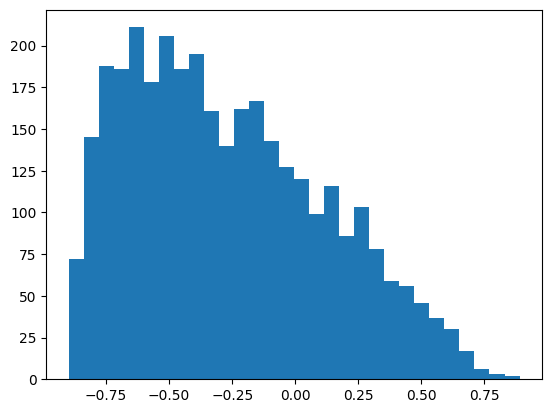

In [15]:
plt.hist(all_resilience_index, bins=30)

In [16]:
torch.save(model.state_dict(), "../checkpoints/Feb2_heat_model_v3_nosp.pth")